## Demand forcasting
Ref: https://nextjournal.com/eric-brown/forecasting-with-prophet-part-4

https://colab.research.google.com/drive/1jHJ0T7nWFHE1tH9Xh2xMNbjoL8vhls9q#scrollTo=CHQHLKLqmHcj

In [1]:
import numpy as np
import pandas as pd

import random
import statsmodels.formula.api as smf

import matplotlib.pyplot as plt
import seaborn as sns
#sns.set()

from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

plt.style.use('ggplot')
plt.rcParams['figure.figsize']=(20,10)

pd.options.display.float_format = '{:,.2f}'.format

# Import statements required for Plotly 
import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls

In [2]:
df = pd.read_csv('data.csv',  parse_dates=['InvoiceDate'])

In [3]:
# transforming into datetime
df.index = pd.to_datetime(df['InvoiceDate'], infer_datetime_format=True)

df.drop('InvoiceDate', axis=1, inplace=True)

# checking the dataset
df.head()

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country
InvoiceDate,,,,,,,
2010-12-01 08:26:00,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,"17,850.00",United Kingdom
2010-12-01 08:26:00,536365,71053,WHITE METAL LANTERN,6,3.39,"17,850.00",United Kingdom
2010-12-01 08:26:00,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,"17,850.00",United Kingdom
2010-12-01 08:26:00,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,"17,850.00",United Kingdom
2010-12-01 08:26:00,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,"17,850.00",United Kingdom


In [4]:
# checking for missing values
(df.isnull().sum()/ df.shape[0]).sort_values(ascending=False)

CustomerID    0.25
Description   0.00
InvoiceNo     0.00
StockCode     0.00
Quantity      0.00
UnitPrice     0.00
Country       0.00
dtype: float64

25% of missing values on customer data is quite significant, and trying to predict them would be too arbitrary. We're better off just deleting them.

In [5]:
df_clean = df.copy()

df_clean.dropna(axis=0, inplace=True)

df_clean.head()

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country
InvoiceDate,,,,,,,
2010-12-01 08:26:00,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,"17,850.00",United Kingdom
2010-12-01 08:26:00,536365,71053,WHITE METAL LANTERN,6,3.39,"17,850.00",United Kingdom
2010-12-01 08:26:00,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,"17,850.00",United Kingdom
2010-12-01 08:26:00,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,"17,850.00",United Kingdom
2010-12-01 08:26:00,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,"17,850.00",United Kingdom


### Fixing some data
The variable `Quantity` has negative values, which makes no sense. To fix that, we're going to drop the rows that have negative values for quantity.

Also, we're going to set `CustomerID` to integer.

Finally, we're going to transform `Description` to lower case.

In [6]:
# fixing Quantity
df_clean = df_clean[df_clean.Quantity > 0]

# fixing CustomerID
df_clean['CustomerID'] = df_clean['CustomerID'].astype('int64')

In [7]:
# creating a new features
df_clean['AmountSpent'] = df_clean['Quantity'] * df_clean['UnitPrice']

In [8]:
# statistical distribution of the data
df_clean.describe()

,Quantity,UnitPrice,CustomerID,AmountSpent
count,"397,924.00","397,924.00","397,924.00","397,924.00"
mean,13.02,3.12,"15,294.32",22.39
std,180.42,22.10,"1,713.17",309.06
min,1.00,0.00,"12,346.00",0.00
25%,2.00,1.25,"13,969.00",4.68
50%,6.00,1.95,"15,159.00",11.80
75%,12.00,3.75,"16,795.00",19.80
max,"80,995.00","8,142.75","18,287.00","168,469.60"


#### Statistical Distribution Highlights
* `Price`
  * The minimum price is £ 0,00, which means that the store gives out some items.
  * The average price of the products is £ 3,11.
  * The most expensive item costs £ 8.142,75.
  * Even though there are expensive items, most of them are cheap.
* `Quantity`
  * The average is actually above the 75th percentile, which indicates that most purchases are made in larger quantities. The source of the data says that this store caters to wholesalers. Even though this could explain it, they're not the only type of customers, since the average is not wholesale worthy.
* `AmountSpent`
  * In this regard, it's really interesting to see again, that the spending pattern is actually cheap. Of course, we don't have data on entire orders, but people don't tend to spend a lot on the items.


In [9]:
# statistical distribution of categorical features
df_clean.describe(include='O')

,InvoiceNo,StockCode,Description,Country
count,397924,397924,397924,397924
unique,18536,3665,3877,37
top,576339,85123A,WHITE HANGING HEART T-LIGHT HOLDER,United Kingdom
freq,542,2035,2028,354345


#### Checking Best Selling Products
With the data we have, it's easy to see our best selling items. Let's check them out.

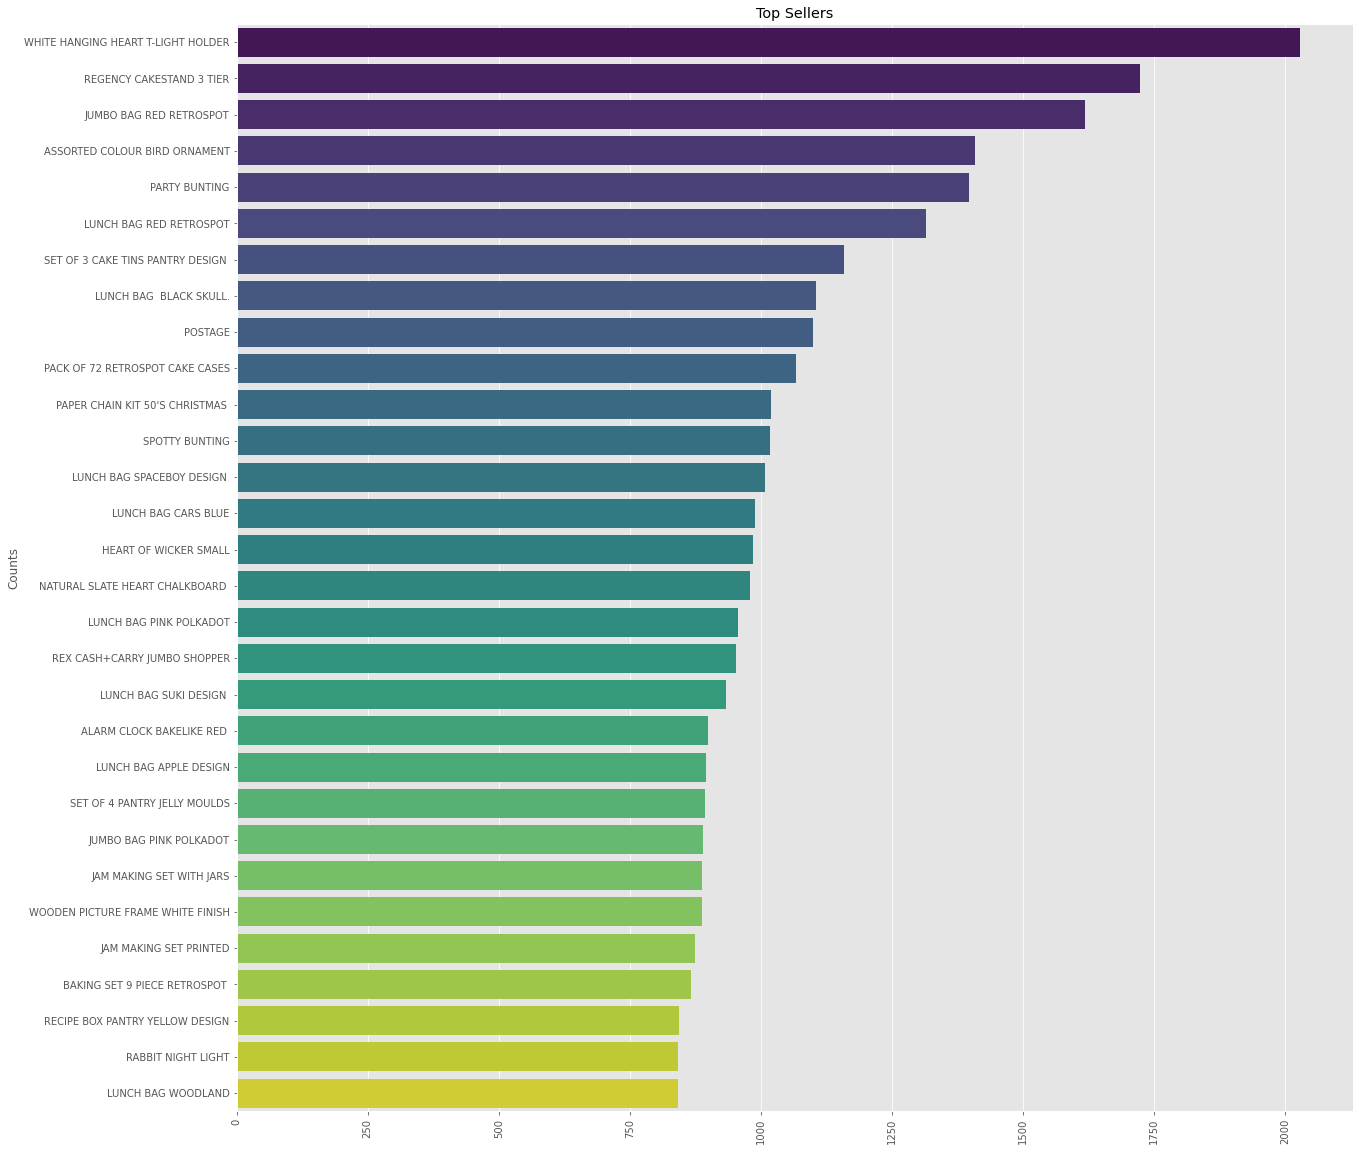

In [10]:
# checking best selling products
description_counts = df_clean.Description.value_counts().sort_values(ascending=False).iloc[0:30]
plt.figure(figsize=(20,20))
sns.barplot(y=description_counts.index, x=description_counts.values, palette='viridis' )
plt.ylabel("Counts")
plt.title("Top Sellers");
plt.xticks(rotation=90);

#### Best Selling Countries
We have seen that this business makes sales to 37 different countries. But what countries buy the most? That's easy to check:

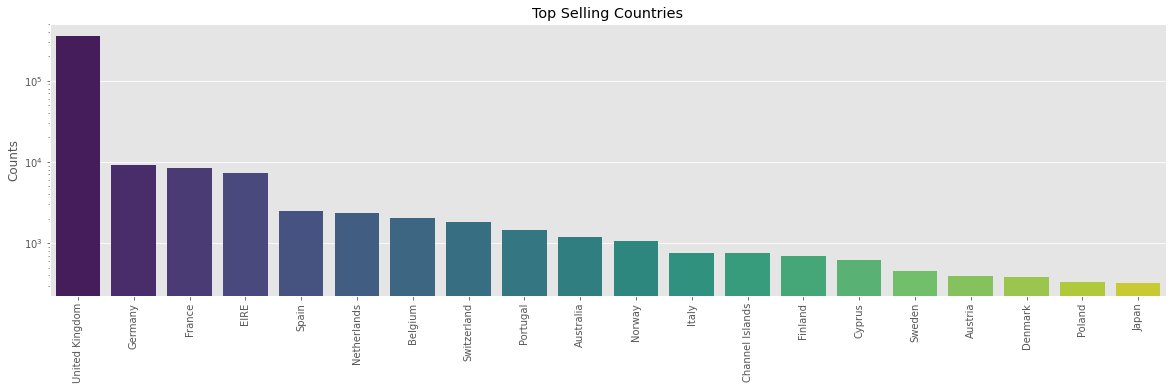

In [11]:
# best selling countries
country_counts = df_clean.Country.value_counts().sort_values(ascending=False).iloc[0:20]
plt.figure(figsize=(20,5))
sns.barplot(x=country_counts.index, y=country_counts.values, palette="viridis")
plt.ylabel("Counts")
plt.title("Top Selling Countries");
plt.xticks(rotation=90);
plt.yscale("log")

#### Statistical Distribution of Categorical Features

* This company sells to 37 different countries around the world.
* Again, the number of unique Invoice Numbers vs the quantity of rows shows that most invoices have lots of products, once again reinforcing the idea of wholesalers.
* Being UK based, it makes sense that it sells the most to the UK.
* They carry almost 4.000 different products.

## Time Series Analysis

<center><img width="40%" src="https://image.freepik.com/free-vector/variety-time-objects-man-landing-page_52683-23310.jpg"></center>


As you could see from the beginning of the analysis, we're dealing with **Time Series** here. 

Time Series are sequences of observations registered in a regular period of time.

This is a big deal because we measure everything in time. In this case, we're talking about sales over a given period of time.

### Real Business Applications

The dataset we're using is from a UK retailer on their sales over a period of time. In the real world, they would use this data for:
* Analyzing previous periods to see what went right and wrong (BI)
* Use this data to make predictions for the future (Data Science)

Ok. But are these predictions any good? Are they a guarantee of anything?

They don't guarantee anything, especially because we're not analyzing exterior factors like weather, disasters, fires, and whatnot. Nevertheless, they can be a reliable source of information, that can help with:

* Stock
* Business strategies for new products, sales, etc.
* Marketing

And a lot more.

First, let's prepare our data, and then dive into Machine Learning.

In [12]:
# creating new features to help with the Time Series Analysis
df_clean["Year"] = df_clean.index.year
df_clean["Quarter"] = df_clean.index.quarter
df_clean["Month"] = df_clean.index.month
df_clean["Week"] = df_clean.index.isocalendar().week
df_clean["Weekday"] = df_clean.index.weekday
df_clean["Day"] = df_clean.index.day
df_clean["Dayofyear"] = df_clean.index.dayofyear
df_clean["Date"] = pd.DatetimeIndex(df_clean.index).date

# checking new features
df_clean.head()

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,AmountSpent,Year,Quarter,Month,Week,Weekday,Day,Dayofyear,Date
InvoiceDate,,,,,,,,,,,,,,,,
2010-12-01 08:26:00,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,17850,United Kingdom,15.30,2010,4,12,48,2,1,335,2010-12-01
2010-12-01 08:26:00,536365,71053,WHITE METAL LANTERN,6,3.39,17850,United Kingdom,20.34,2010,4,12,48,2,1,335,2010-12-01
2010-12-01 08:26:00,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,17850,United Kingdom,22.00,2010,4,12,48,2,1,335,2010-12-01
2010-12-01 08:26:00,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,17850,United Kingdom,20.34,2010,4,12,48,2,1,335,2010-12-01
2010-12-01 08:26:00,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,17850,United Kingdom,20.34,2010,4,12,48,2,1,335,2010-12-01


In [13]:
# convert variables to either 0 or 1
df_clean['Weekend'] = 0
df_clean.loc[(df_clean.Weekday == 5) | (df_clean.Weekday == 6), 'Weekend'] = 1

In [14]:
df_clean.head()

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,AmountSpent,Year,Quarter,Month,Week,Weekday,Day,Dayofyear,Date,Weekend
InvoiceDate,,,,,,,,,,,,,,,,,
2010-12-01 08:26:00,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,17850,United Kingdom,15.30,2010,4,12,48,2,1,335,2010-12-01,0
2010-12-01 08:26:00,536365,71053,WHITE METAL LANTERN,6,3.39,17850,United Kingdom,20.34,2010,4,12,48,2,1,335,2010-12-01,0
2010-12-01 08:26:00,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,17850,United Kingdom,22.00,2010,4,12,48,2,1,335,2010-12-01,0
2010-12-01 08:26:00,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,17850,United Kingdom,20.34,2010,4,12,48,2,1,335,2010-12-01,0
2010-12-01 08:26:00,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,17850,United Kingdom,20.34,2010,4,12,48,2,1,335,2010-12-01,0


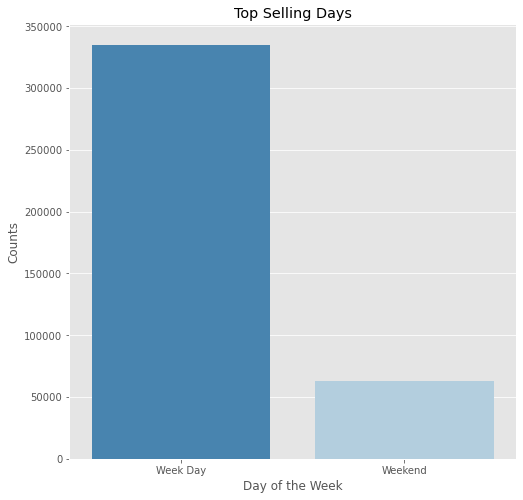

In [15]:
# checking values for weekdays and weekends
weekend_counts = df_clean.Weekend.value_counts().sort_values(ascending=False)
fig, ax = plt.subplots(figsize=(8,8))
sns.barplot(x=weekend_counts.index, y=weekend_counts.values, palette="Blues_r")
plt.ylabel("Counts")
plt.xlabel("Day of the Week")
labels = [item.get_text() for item in ax.get_xticklabels()]
labels[1] = 'Weekend'
labels[0] = 'Week Day'
ax.set_xticklabels(labels)
plt.title("Top Selling Days");

Surprisingly, this company sells way more on weekdays when comparing to weekends. Of course these numbers don't jump at you, when you consider there are more days on a week than on a weekend. However, on average, the company has sold, on average:
* 31.387,5 items a day on weekends.
* 67.029,8 items a day on weekdays.


For our analysis and prediction, let's focus on **Daily Sales**.

So, let's group our sales by product per day.

In [16]:
# creating grouped features
grouped_features = ["Date", "Year", "Quarter","Month", "Week", "Weekday", "Dayofyear", "Day",
                    "StockCode"]

In [17]:
# creating daily features
daily_data = pd.DataFrame(df_clean.groupby(grouped_features).Quantity.sum(),
                          columns=["Quantity"])
daily_data["AmountSpent"] = df_clean.groupby(grouped_features).AmountSpent.sum()
daily_data = daily_data.reset_index()
daily_data.head()

,Date,Year,Quarter,Month,Week,Weekday,Dayofyear,Day,StockCode,Quantity,AmountSpent
0,2010-12-01,2010,4,12,48,2,335,1,10002,60,51.00
1,2010-12-01,2010,4,12,48,2,335,1,10125,2,1.70
2,2010-12-01,2010,4,12,48,2,335,1,10133,5,4.25
3,2010-12-01,2010,4,12,48,2,335,1,15044B,1,2.95
4,2010-12-01,2010,4,12,48,2,335,1,15056BL,20,113.00


In [18]:
# statistical distribution of the grouped data
daily_data.loc[:, ["Quantity", "AmountSpent"]].describe()

,Quantity,AmountSpent
count,"222,383.00","222,383.00"
mean,23.30,40.07
std,243.05,418.47
min,1.00,0.00
25%,3.00,6.80
50%,9.00,15.80
75%,24.00,34.00
max,"80,995.00","168,469.60"


As you can see, we have some **Outliers** that can influence our results on both ends of the dataset. For that reason, let's clean them up.

In [19]:
# identifying drop points
low_quantity = daily_data.Quantity.quantile(0.01)
high_quantity = daily_data.Quantity.quantile(0.99)
print((low_quantity, high_quantity))

(1.0, 225.0)


In [20]:
# identifying drop points
low_AmountSpent = daily_data.AmountSpent.quantile(0.01)
high_AmountSpent = daily_data.AmountSpent.quantile(0.99)
print((low_AmountSpent, high_AmountSpent))

(0.76, 380.81439999999947)


In [21]:
# saving shape to count lost entries
samples = daily_data.shape[0]

In [22]:
# selecting entries
daily_data = daily_data.loc[
    (daily_data.Quantity >= low_quantity) & (daily_data.Quantity <= high_quantity)]
daily_data = daily_data.loc[
    (daily_data.AmountSpent >= low_AmountSpent) & (daily_data.AmountSpent <= high_AmountSpent)]

In [23]:
# counting lost entries
samples - daily_data.shape[0]

5518

In [24]:
# preparing the dataset for 
df_ts=daily_data.groupby('Date',as_index=False)['AmountSpent'].sum()
df_ts['Date'] = pd.to_datetime(df_ts['Date'], format="%Y-%m-%d")
df_ts.index = pd.to_datetime(df_ts['Date'], format="%Y-%m-%d")
df_ts.drop('Date', axis=1, inplace=True)

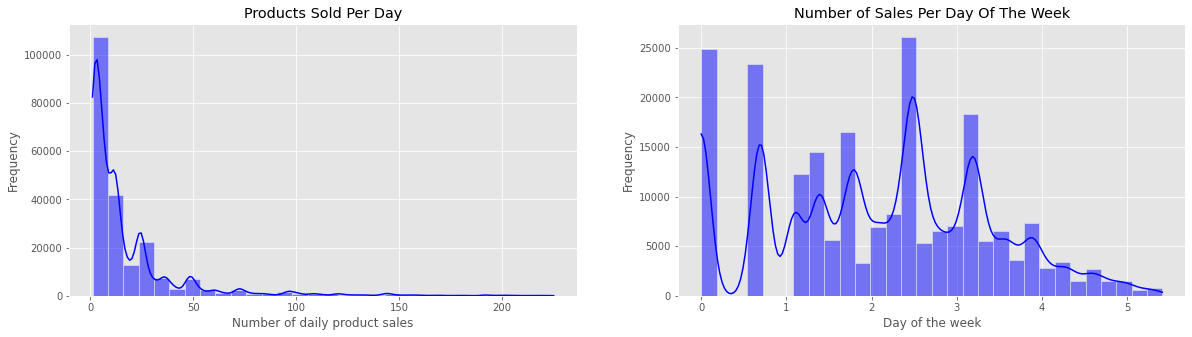

In [25]:
# 
fig, ax = plt.subplots(1,2,figsize=(20,5))
sns.histplot(daily_data.Quantity.values, kde=True, ax=ax[0], color="Blue", bins=30);
sns.histplot(np.log(daily_data.Quantity.values), kde=True, ax=ax[1], color="Blue", bins=30);
ax[0].set_xlabel("Number of daily product sales");
ax[0].set_ylabel("Frequency");
ax[0].set_title("Products Sold Per Day");
ax[1].set_xlabel("Day of the week");
ax[1].set_ylabel("Frequency");
ax[1].set_title("Number of Sales Per Day Of The Week");

## Preparing the Data for Machine Learning

For our forecast we'll use Facebook's **Prophet**.

It's a very robust and fairly simple model to use, that's powerful enough to render good results even with little to no tuning, when operating on the right data.

**Stationary Time Series**

When making predictions with Time Series, it's common to worry about whether they're stationary or not. Working with ARIMA, for example, this is essential.

You'll find examples of projects using Prophet without even checking to see if the Time Series is stationary or not. Here, we'll first work on it as is, and then check if it's stationary, if it's not, we'll make it so, and then train the model again to compare the results.

In [26]:
# checking our data
df_ts.head()

,AmountSpent
Date,
2010-12-01,"31,546.98"
2010-12-02,"32,935.45"
2010-12-03,"19,411.87"
2010-12-05,"28,582.51"
2010-12-06,"23,563.71"


In [27]:
# importing Prophet
from prophet import Prophet
import logging
logging.getLogger().setLevel(logging.ERROR)

#### Working with Prophet

Prophet needs a very specific kind of dataframe for it to work on. What we need is:
* Date column as `ds`.
* Value column as `y`.

Let's make it so.

In [28]:
# setting up the dataframe
df_ts = df_ts.reset_index()
df_ts.columns = ['ds', 'y']
df_ts.head()

,ds,y
0,2010-12-01,"31,546.98"
1,2010-12-02,"32,935.45"
2,2010-12-03,"19,411.87"
3,2010-12-05,"28,582.51"
4,2010-12-06,"23,563.71"


#### Stationary Test
As stated before, we'll analyze the effects of having a Stationary Time Series to work upon with Prophet.

First, let's check if our data is stationary.

In [29]:
from statsmodels.tsa.stattools import adfuller
# extracting values
X = df_ts.y

# apply ADF and print results
result = adfuller(X)
print('Augmented Dickey–Fuller')
print('Statistical Test: {:.4f}'.format(result[0]))
print('P Value: {:.10f}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
	print('\t{}: {:.4f}'.format(key, value))

Augmented Dickey–Fuller
Statistical Test: -1.4142
P Value: 0.5754323865
Critical Values:
	1%: -3.4530
	5%: -2.8715
	10%: -2.5721


Bingo. Our P value is at 0.57, which means our Time Series is not stationary.

Let's see how Prophet deals with it for our baseline.

In [30]:
# setting prediction size to 30 days
prediction_size = 30
train_df = df_ts[:-prediction_size]

In [38]:
# instantiating the model
model = Prophet(interval_width=0.95, yearly_seasonality=True, daily_seasonality=False )

# training the model
model.fit(train_df)

# make predictions
future = model.make_future_dataframe(periods=prediction_size)

forecast = model.predict(future)

In [39]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
300,2011-11-30,"34,162.40","24,416.91","43,874.35"
301,2011-12-01,"37,871.04","28,563.59","47,230.78"
302,2011-12-02,"31,462.85","21,941.27","40,744.15"
303,2011-12-03,"38,796.94","29,149.36","48,225.01"
304,2011-12-04,"24,556.12","14,663.38","33,621.90"


In [40]:
plot_plotly(model, forecast, xlabel='date', ylabel='sales')

In [41]:
plot_components_plotly(model, forecast)

In [42]:
# define a function to make a dataframe containing the predicion and actual values
def make_comparison_dataframe(historical, forecast):
  return forecast.set_index('ds')[['yhat', 'yhat_lower',
                                'yhat_upper']].join(historical.set_index('ds'))
cmp_df = make_comparison_dataframe(df_ts, forecast)

# define a function to calculate MAPE and MAE
def calculate_forecast_errors(df_ts, prediction_size):

  df = df_ts.copy()
  df['e'] = df['y'] - df['yhat']
  df['p'] = 100 * df['e'] / df['y']
  predicted_part = df[-prediction_size:]

  error_mean = lambda error_name: np.mean(np.abs(predicted_part[error_name]))

  return{'MAPE': error_mean('p'), 'MAE': error_mean('e')}

# print the MAPE and MAE
for err_name, err_value in calculate_forecast_errors(cmp_df, prediction_size).items():
  print(err_name, err_value)

MAPE 17.696802082267872
MAE 5968.318408713376


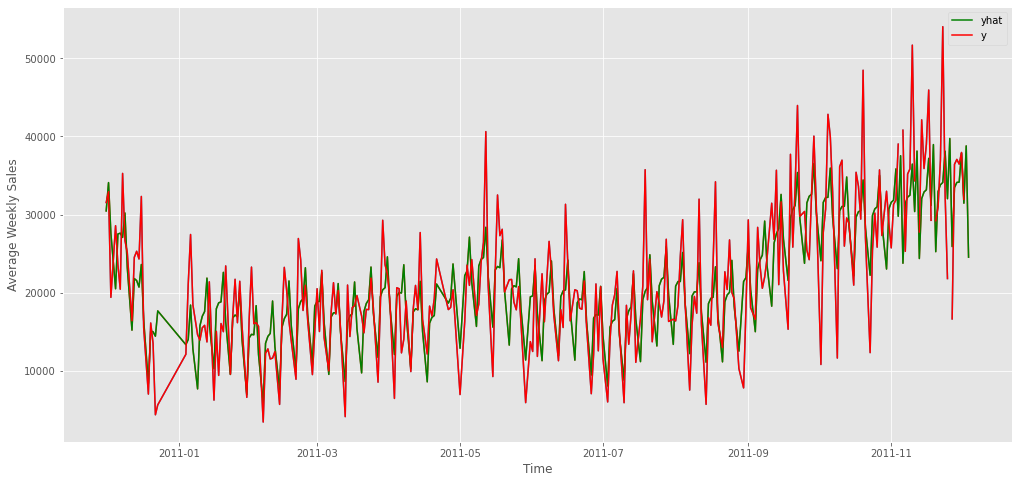

In [59]:
# checking the results
fig, ax = plt.subplots(figsize=(17,8))

plt.plot(cmp_df['yhat'])
#plt.plot(cmp_df['yhat_lower'])
#plt.plot(cmp_df['yhat_upper'])
plt.plot(cmp_df['y'])

plt.xlabel('Time')
plt.ylabel('Average Weekly Sales')
ax.plot(cmp_df['yhat'], label='yhat', color="g")
#ax.plot(cmp_df['yhat_lower'], label='yhat_lower')
#ax.plot(cmp_df['yhat_upper'], label='yhat_upper')
ax.plot(cmp_df['y'], label='y' , color="r")
ax.legend()
plt.show()

#### Conclusions
All of that seem great, however, how do we know if our predictions are any good?

Here, we're using to metrics for evaluation:
* Mean Absolute Percentage Error - How much do our predictions differ from the actual values in percentages.
* Mean Absolute Error - Absolute error value between the predicted value and the actual value.

# Stationary Time Series
This is quite a big error. We can't use it as a reliable source of information.

One of the things we can do to try and improve our results is making our Time Series stationary, and see how it goes.

We'll do that by using a technique called **Differencing**. You can find out more about this method [here](https://machinelearningmastery.com/remove-trends-seasonality-difference-transform-python/).

In [49]:
# preparing for transformation
df_ts.index = pd.to_datetime(df_ts['ds'], format="%Y-%m-%d")
df_ts.drop('ds', axis=1, inplace=True)
df_ts.head()

,y
ds,
2010-12-01,"31,546.98"
2010-12-02,"32,935.45"
2010-12-03,"19,411.87"
2010-12-05,"28,582.51"
2010-12-06,"23,563.71"


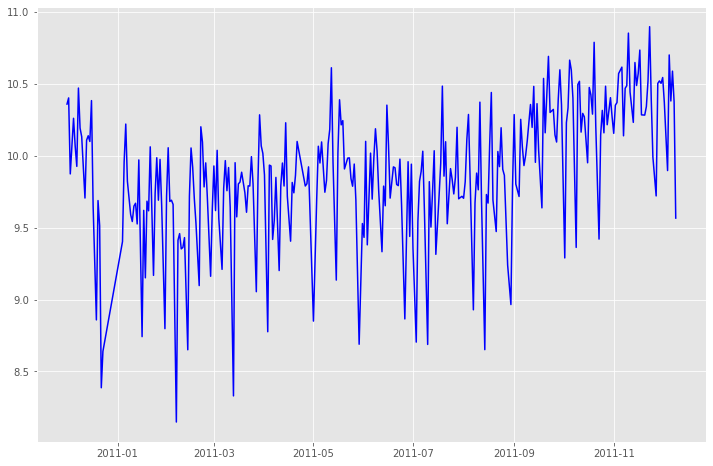

In [55]:
# log transformation
fig, ax = plt.subplots(figsize=(12,8))
ts_log = np.log(df_ts)
plt.plot(ts_log, color="b");

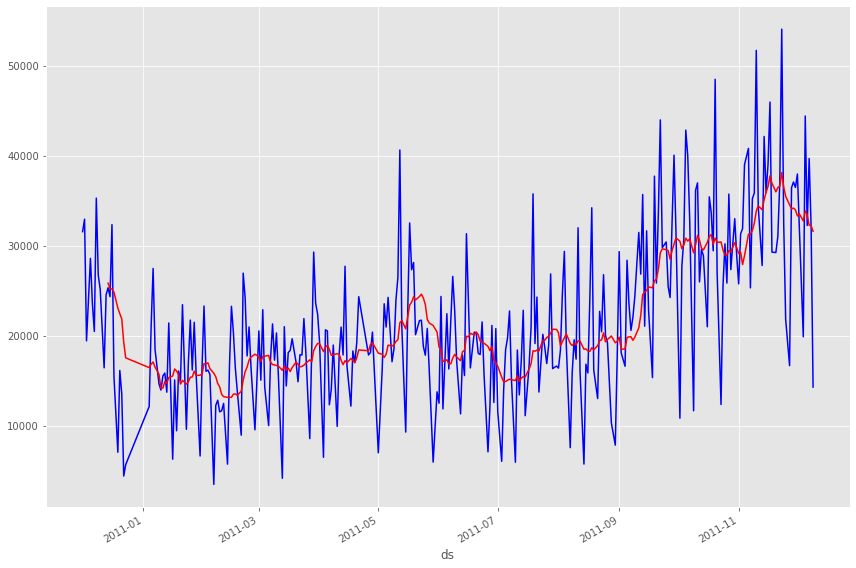

In [68]:
# check the original plot
ma = df_ts.rolling(12).mean()

fig, ax = plt.subplots(figsize=(12,8))
df_ts.plot(ax=ax, color='b', legend=False)
ma.plot(ax=ax, color='r', legend=False)
plt.tight_layout();

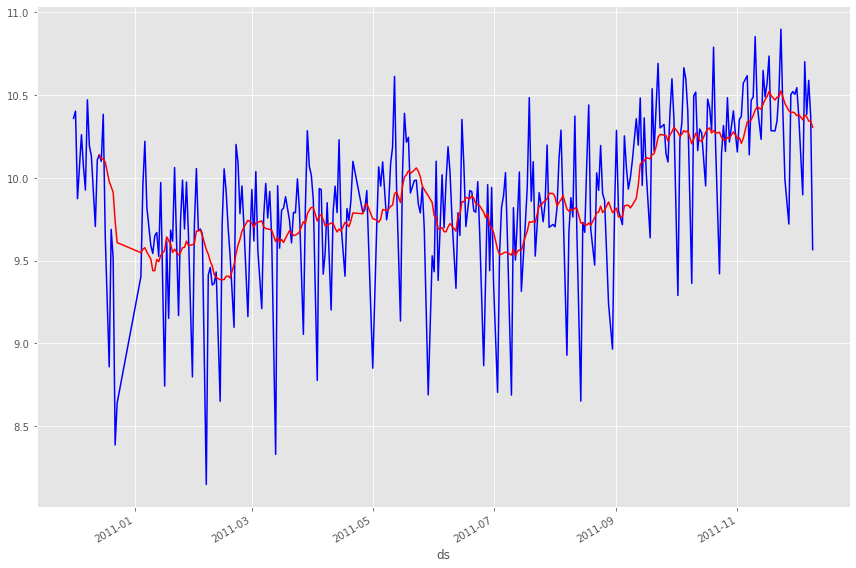

In [61]:
# applying the log
df_log = np.log(df_ts)
ma_log = df_log.rolling(12).mean()

fig, ax = plt.subplots(figsize=(12,8))
df_log.plot(ax=ax, color='b', legend=False)
ma_log.plot(ax=ax, color='r', legend=False)
plt.tight_layout()

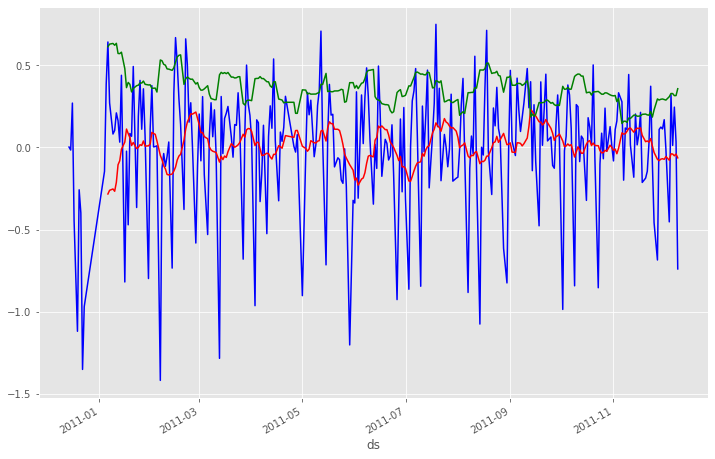

In [69]:
# subtracting the log average from the data
df_sub = (df_log - ma_log).dropna()
ma_sub = df_sub.rolling(12).mean()
std_sub = df_sub.rolling(12).std()

fig, ax = plt.subplots(figsize=(12,8))
df_sub.plot(ax=ax, color='b',legend=False)
ma_sub.plot(ax=ax, color='r', legend=False)
std_sub.plot(ax=ax, color='g', legend=False)
plt.show();

In [70]:
# repeating the ADF
X_sub = df_sub.y.values

# applying ADF and printing the result
result_sub = adfuller(X_sub)
print('Augmented Dickey–Fuller')
print('Statistical Test: {:.4f}'.format(result_sub[0]))
print('P Value: {:.10f}'.format(result_sub[1]))
print('Critical Values:')
for key, value in result_sub[4].items():
	print('\t{}: {:.4f}'.format(key, value))

Augmented Dickey–Fuller
Statistical Test: -5.4029
P Value: 0.0000033403
Critical Values:
	1%: -3.4538
	5%: -2.8718
	10%: -2.5723


That's already good enough, but with differencing we can make it even better, and take it as stationary with an even higher level of confidence.

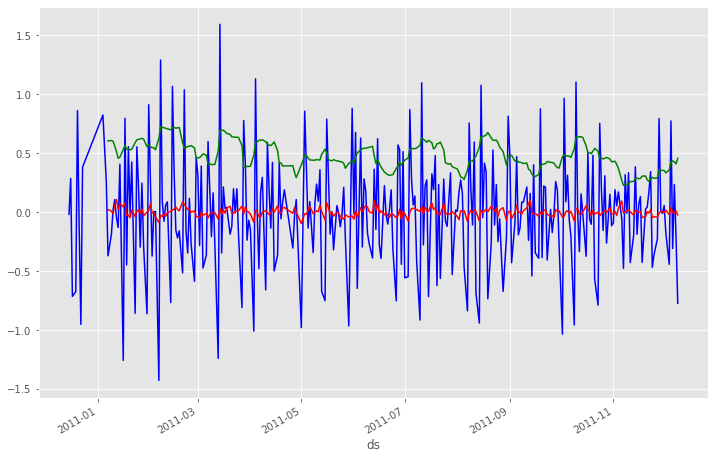

Augmented Dickey–Fuller
Statistical Test: -5.4029
P Value: 0.0000033403
Critical Values:
	1%: -3.4538
	5%: -2.8718
	10%: -2.5723


In [72]:
# applying differencing
df_diff = df_sub.diff(1)
ma_diff = df_diff.rolling(12).mean()
std_diff = df_diff.rolling(12).std()

fig, ax = plt.subplots(figsize=(12,8))
df_diff.plot(ax=ax, color='b', legend=False)
ma_diff.plot(ax=ax, color='r', legend=False)
std_diff.plot(ax=ax, color='g', legend=False)
plt.show()

# extracting values only
X_diff = df_diff.y.dropna().values

# applying ADF and printing the result
result_diff = adfuller(X_diff)
print('Augmented Dickey–Fuller')
print('Statistical Test: {:.4f}'.format(result_sub[0]))
print('P Value: {:.10f}'.format(result_sub[1]))
print('Critical Values:')
for key, value in result_sub[4].items():
	print('\t{}: {:.4f}'.format(key, value))

#### Working on the Stationary Time Series
Now that our Time Series is Stationary, let's work on it.

In [74]:
# reset index to come back to Prophet's format
df_log.reset_index(inplace=True)

In [75]:
df_log.head()

,ds,y
0,2010-12-01,10.36
1,2010-12-02,10.40
2,2010-12-03,9.87
3,2010-12-05,10.26
4,2010-12-06,10.07


In [76]:
# again, setting prediction size to 30
prediction_size = 30
train_df = df_log[:-prediction_size]

In [77]:
# instantiating the model
m = Prophet(interval_width=0.95, yearly_seasonality=True, daily_seasonality=False )

# training the model
m.fit(train_df)

# make predictions
future = m.make_future_dataframe(periods=prediction_size)

forecast = m.predict(future)

forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2010-12-01,9.85,9.84,10.97,9.85,9.85,0.55,0.55,0.55,0.05,0.05,0.05,0.50,0.50,0.50,0.00,0.00,0.00,10.40
1,2010-12-02,9.85,10.01,11.07,9.85,9.85,0.71,0.71,0.71,0.21,0.21,0.21,0.50,0.50,0.50,0.00,0.00,0.00,10.55
2,2010-12-03,9.85,9.74,10.87,9.85,9.85,0.44,0.44,0.44,-0.05,-0.05,-0.05,0.48,0.48,0.48,0.00,0.00,0.00,10.28
3,2010-12-05,9.85,9.20,10.28,9.85,9.85,-0.10,-0.10,-0.10,-0.54,-0.54,-0.54,0.44,0.44,0.44,0.00,0.00,0.00,9.74
4,2010-12-06,9.85,9.74,10.83,9.85,9.85,0.44,0.44,0.44,0.03,0.03,0.03,0.41,0.41,0.41,0.00,0.00,0.00,10.28


In [79]:
# plotting the forecast
plot_plotly(m, forecast, xlabel='date', ylabel='sales')

In [80]:
# plotting components
plot_components_plotly(m, forecast)

#### Analyzing Components
We can take away some interesting insights from these graphs:
* Confirmation of our daily analysis, showing sales are at their best during weekdays.
* Upward trend.

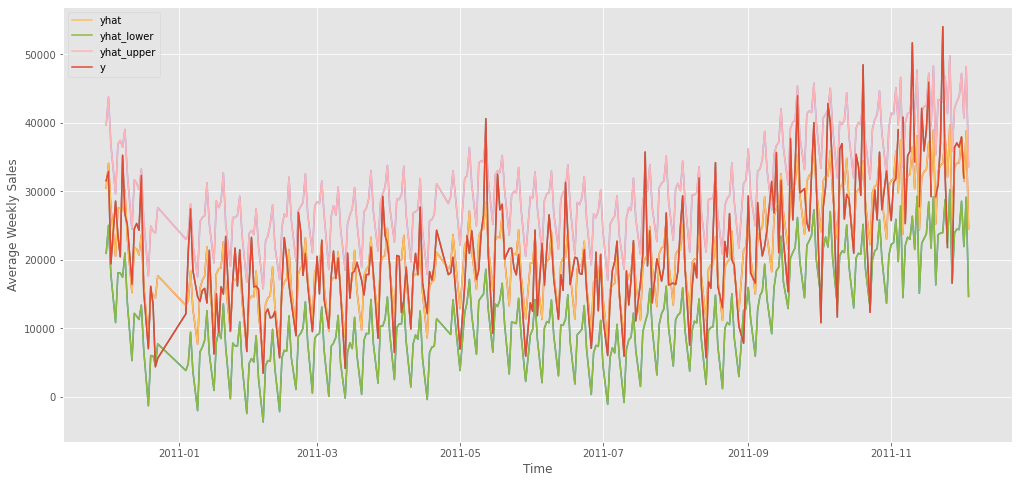

In [81]:
# checking results
fig, ax = plt.subplots(figsize=(17,8))

plt.plot(cmp_df['yhat'])
plt.plot(cmp_df['yhat_lower'])
plt.plot(cmp_df['yhat_upper'])
plt.plot(cmp_df['y'])

plt.xlabel('Time')
plt.ylabel('Average Weekly Sales')
ax.plot(cmp_df['yhat'], label='yhat')
ax.plot(cmp_df['yhat_lower'], label='yhat_lower')
ax.plot(cmp_df['yhat_upper'], label='yhat_upper')
ax.plot(cmp_df['y'], label='y')
ax.legend()
plt.show()

In [83]:
# define a function to make a dataframe containing the predicion and actual values
def make_comparison_dataframe(historical, forecast):
    return forecast.set_index('ds')[['yhat', 'yhat_lower',
                                'yhat_upper']].join(historical.set_index('ds'))
cmp_df = make_comparison_dataframe(df_log, forecast)

# define a function to calculate MAPE and MAE
def calculate_forecast_errors(df_ts, prediction_size):

    df = df_ts.copy()
    df['e'] = df['y'] - df['yhat']
    df['p'] = 100 * df['e'] / df['y']
    predicted_part = df[-prediction_size:]

    error_mean = lambda error_name: np.mean(np.abs(predicted_part[error_name]))

    return{'MAPE': error_mean('p'), 'MAE': error_mean('e')}

# print the MAPE and MAE
for err_name, err_value in calculate_forecast_errors(cmp_df, prediction_size).items():
    print(err_name, err_value)

MAPE 2.200470543427215
MAE 0.2304634340572256


### Conclusions

With and Mean Absolute Percentage Error of less than 2% and an Mean Absolute Error of around 0.19, it's safe to say we have created a model that can become a reliable source of information.

This shows how powerful it is to make predictions on Stationary Data.

Let's see what else we can learn from the data.

In [84]:
# creating a complete dataset
df_final = forecast[['ds', 'yhat']]
df_final.head()

,ds,yhat
0,2010-12-01,10.40
1,2010-12-02,10.55
2,2010-12-03,10.28
3,2010-12-05,9.74
4,2010-12-06,10.28


In [85]:
# visualizing the preditctions as tables
df_final['AmountSpentLog'] = df_log['y']
df_final.head()

<ipython-input-85-e93109ce7770>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,ds,yhat,AmountSpentLog
0,2010-12-01,10.40,10.36
1,2010-12-02,10.55,10.40
2,2010-12-03,10.28,9.87
3,2010-12-05,9.74,10.26
4,2010-12-06,10.28,10.07


In [86]:
# getting the values back to their original scale
df_final['AmountSpent'] = np.exp(df_final['AmountSpentLog'].values)
df_final['AmountSpentPred'] = np.exp(df_final['yhat'].values)
df_final.head(10)

<ipython-input-86-2ea16519590a>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-86-2ea16519590a>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,ds,yhat,AmountSpentLog,AmountSpent,AmountSpentPred
0,2010-12-01,10.40,10.36,"31,546.98","32,745.74"
1,2010-12-02,10.55,10.40,"32,935.45","38,333.57"
2,2010-12-03,10.28,9.87,"19,411.87","29,241.49"
3,2010-12-05,9.74,10.26,"28,582.51","17,036.47"
4,2010-12-06,10.28,10.07,"23,563.71","29,215.99"
5,2010-12-07,10.27,9.93,"20,456.39","28,820.82"
6,2010-12-08,10.23,10.47,"35,273.57","27,659.77"
7,2010-12-09,10.35,10.19,"26,701.30","31,147.73"
8,2010-12-10,10.04,10.13,"25,141.53","22,865.28"
9,2010-12-12,9.42,9.71,"16,415.27","12,393.05"


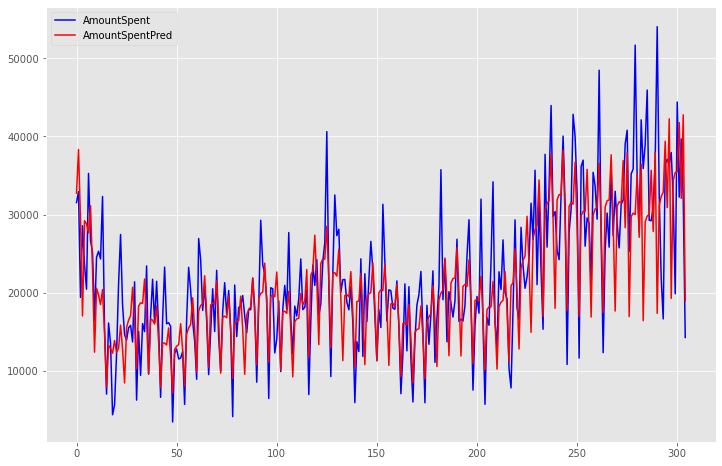

In [88]:
# plotting predictions vs reality
fig, ax = plt.subplots(figsize=(12,8))
df_final['AmountSpent'].plot(ax=ax, color='b',legend=('Amount Spent'))
df_final['AmountSpentPred'].plot(ax=ax, color='r', legend={'Predicted'})
plt.savefig('st_yhat.png')
plt.show()

We can see that our data tends to underestimate sales values, which is not bad, since business need to plan for worst case scenarios.

If we wanted more optimistic predictions, we could use `yhat_upper` instead of `yhat`.

For more conservative predictions, we could use `yhat_lower`.